## Autorzy

- Hubert Lewandowski
- Filip Wielgosz

# Predykcyjne modelowanie wynagrodzeń dla biznesu

**Cel naukowy i biznesowy**: Zbudować replikowalny pipeline ETL → EDA → inżynieria cech → modelowanie (XGBoost) z tunowaniem (Optuna) do **prognozowania `salary_in_usd`**, aby wesprzeć działy HR w **szybszym i bardziej obiektywnym** kształtowaniu widełek płacowych.

**Główne założenia**: integrujemy wiele źródeł (Kaggle), ujednolicamy nazewnictwo, dodajemy cechy semantyczne (zeroshot + embeddings), dzielimy dane na regiony i budujemy modele per‑segment; transparentność zapewniają wykresy EDA oraz interpretowalność SHAP.

**3 kluczowe korzyści dla Biznesu:**
1) **Spójność i fair‑pay** – jednolity, data‑driven punkt odniesienia do decyzji o ofertach.
2) **Skrócone time‑to‑offer** – szybsza kalibracja widełek dla konkretnych ról/regionów.
3) **Scenariusze „co‑jeśli”** – możliwość symulacji wpływu stanowiska, modelu pracy czy wielkości firmy na płacę.


<br><br><br>
## Konfiguracja ścieżek
Ustawiamy katalog bazowy i lokalizację mapowań (`mappings/`) wykorzystywanych w ETL i feature engineering.

In [1]:
import os

BASE_DIR = os.getcwd()
MAPS_DIR = os.path.join(BASE_DIR, "..", "mappings")

<br><br><br>
## Importy modułów projektu
- `ETLPipeline` – ekstrakcja 3 zbiorów z Kaggle, standaryzacja kolumn, wartości i nazw państw.
- `EDA` – opis danych, korelacje (num + kategorie via współczynnik eta), outliers i geografia.
- `FeatureEngineer` – czyszczenie i cechy semantyczne (zeroshot + embeddings) na tytułach ról.
- `RegionEDA` – porównania US+CA+UK vs Rest (mediany, rozkłady, trendy, size/work model).
- `XGBoost` – prosty wrapper na trenowanie i strojenie z Optuną.

In [2]:
from eda import EDA
from region_eda import RegionEDA
from etl import ETLPipeline
from feature_eng import FeatureEngineer
from xgb import XGBoost

<br><br><br>
## ETL – ekstrakcja i standaryzacja
Pobieramy 3 publiczne zbiory **Kaggle** i łączymy je w jedną tabelę. `transform()` korzysta z mapowań kolumn (`columns.json`) i wartości (`values.json`), normalizuje nazwy krajów (ISO → `name_short`) i usuwa indeksy‑wydmuszki; następnie deduplikacja i sort po `work_year`.

In [3]:
etl = ETLPipeline()

etl.extract("ruchi798/data-science-job-salaries", "ds_salaries.csv")
etl.extract("sazidthe1/data-science-salaries", "data_science_salaries.csv")
etl.extract("arnabchaki/data-science-salaries-2025", "salaries.csv")

etl.transform(
    columns_map=os.path.join(MAPS_DIR, "columns.json"),
    values_map=os.path.join(MAPS_DIR, "values.json"),
)

dataset = etl.load()

Std. custom: 100%|██████████| 3/3 [00:00<00:00, 44.03it/s]


<br><br><br>
## EDA – opis podstawowy, korelacje, outliers i geografia
Uruchamiamy metody: 
- `describe()` → statystyki i unikalności; 
- `correlations()` → skorelowanie cech z celem (`salary_in_usd`), w tym **eta** dla kategorii; 
- `outliers()` → box‑plota/Top‑N kategorie; 
- `geography_salary()` → top lokalizacje wg **skorygowanego** 95. percentyla.

Missing values or NaNs: 0
Data dimensions (w x h): 52,938 x 11

                    unique_values
salary_in_usd               10537
salary                       9484
job_title                     363
employee_residence             98
company_location               92
salary_currency                27
work_year                       6
experience_level                4
employment_type                 4
work_model                      3
company_size                    3

                    mean        std     min      25%       50%       75%  \
work_year        2024.20       0.76  2020.0   2024.0    2024.0    2025.0   
salary         161954.80  300361.98  4000.0  96600.0  140000.0  193000.0   
salary_in_usd  151657.66   77900.82  2859.0  96500.0  139587.0  191000.0   

                      max  
work_year          2025.0  
salary         30400000.0  
salary_in_usd    800000.0  

                   unique             top   freq
experience_level        4          Senior  27989
employment_

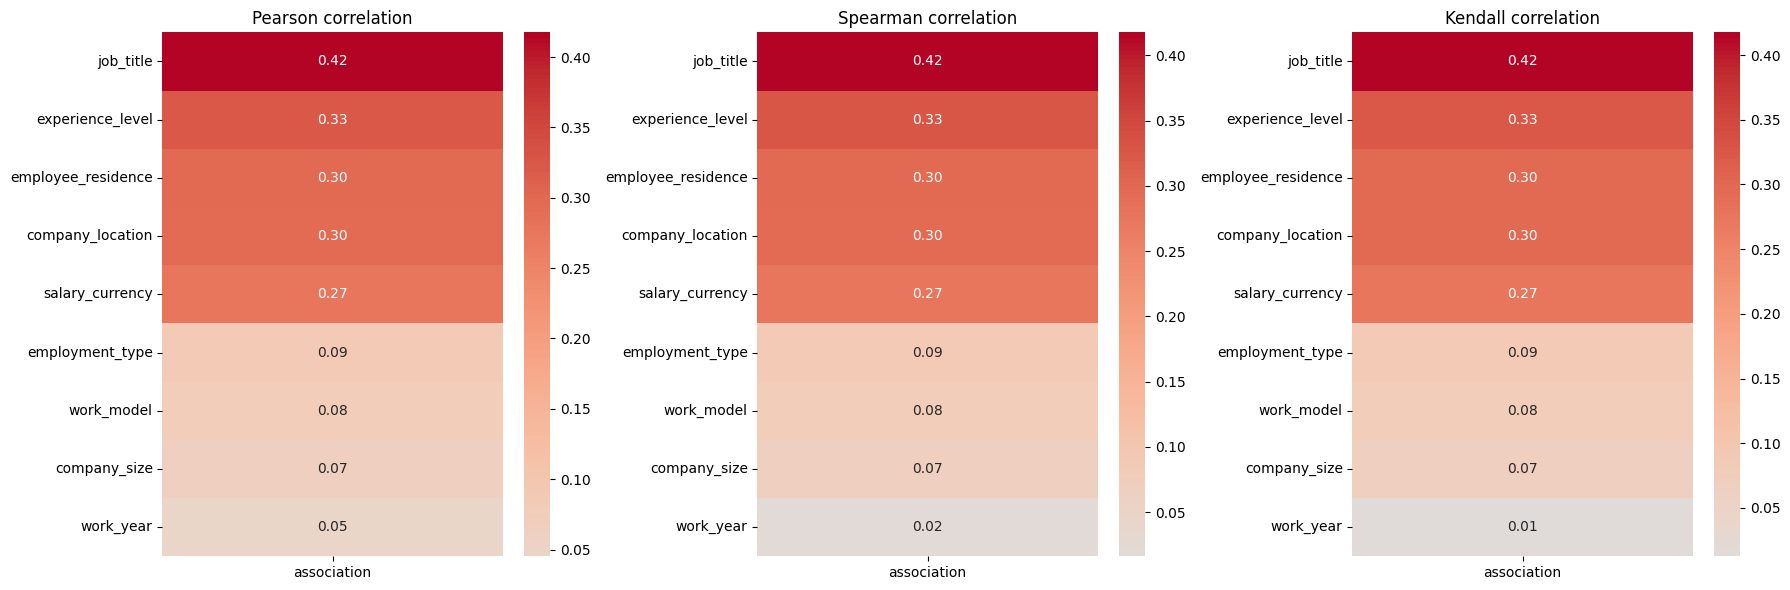

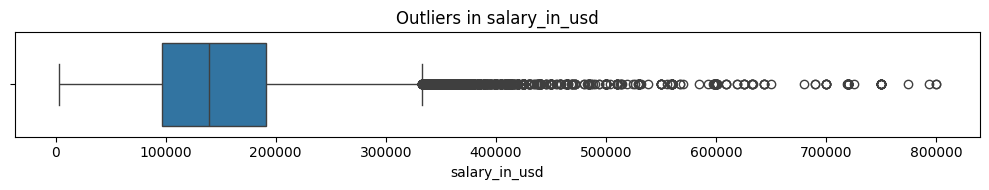

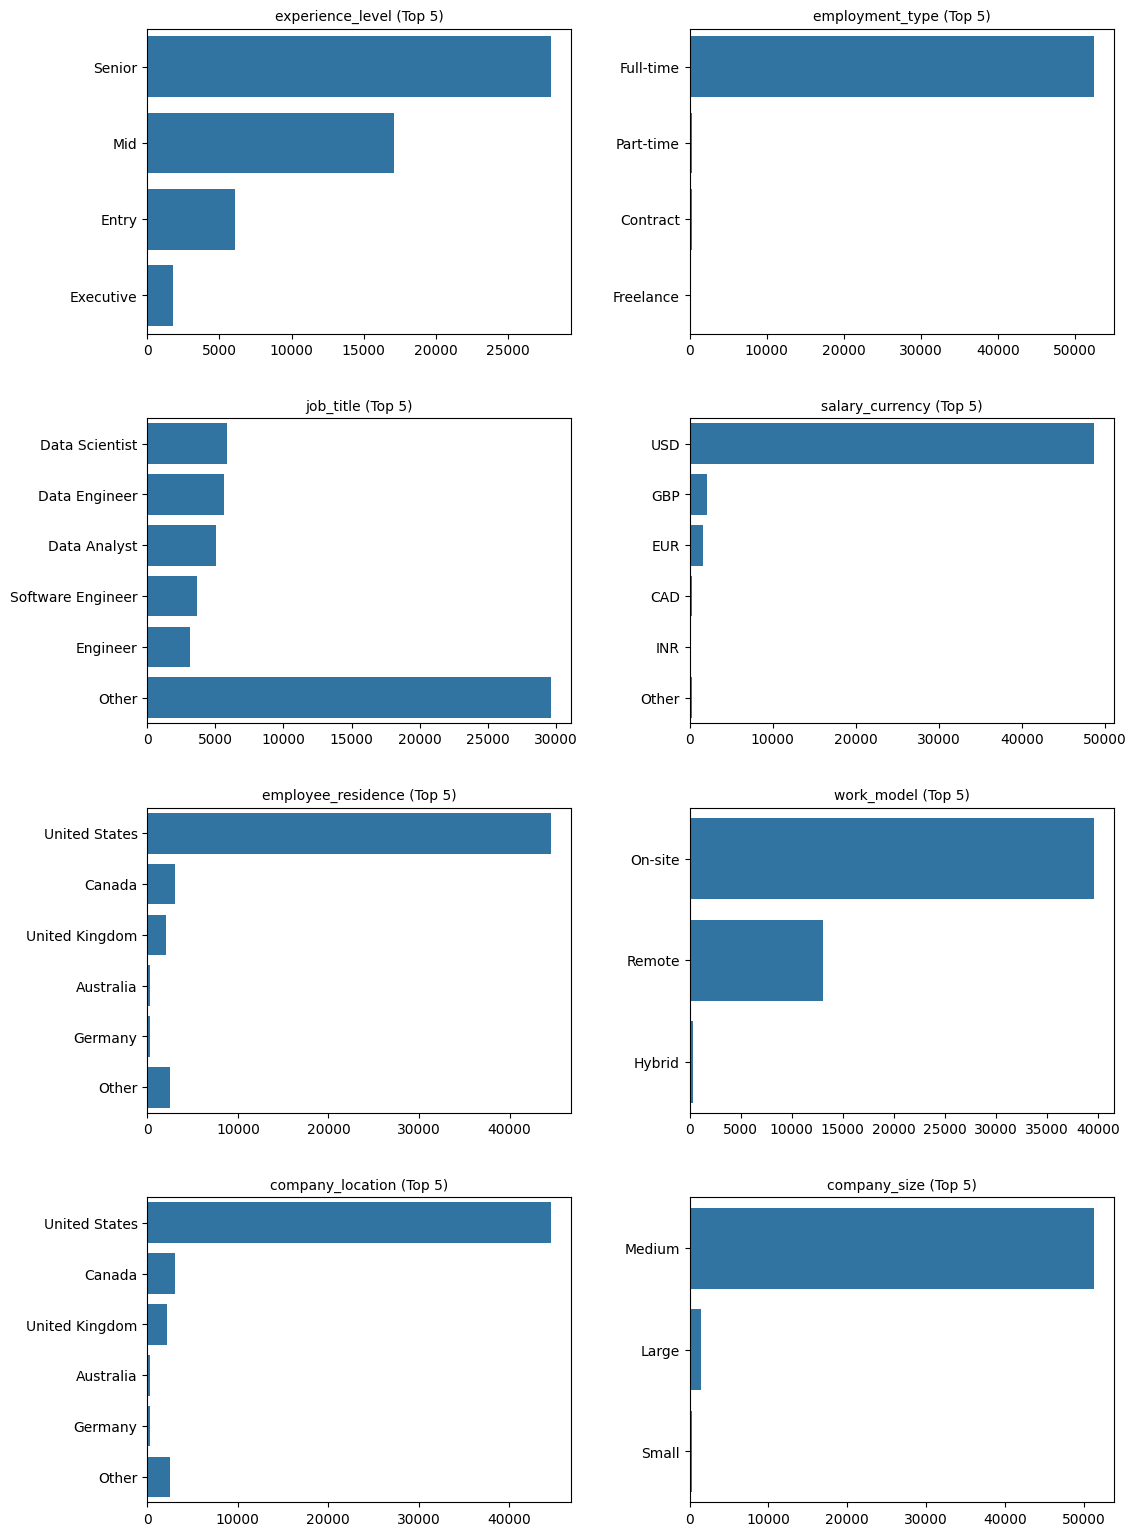

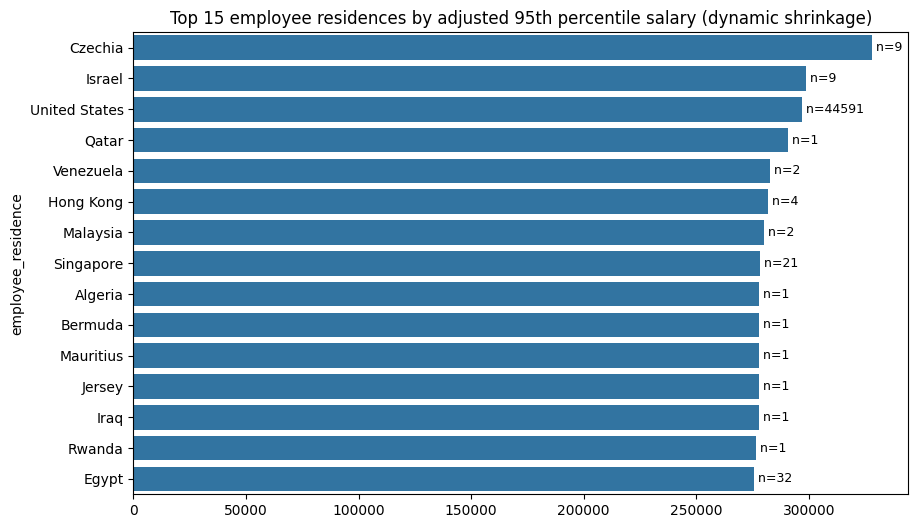

In [4]:
eda = EDA(dataset)
eda.describe()
eda.correlations(target="salary_in_usd", exclude_cols=["salary"])
eda.outliers(exclude_cols=["work_year", "salary"], top_n=5)
eda.geography_salary()

### EDA – kluczowe wyniki i interpretacje

#### Top lokalizacje wg 95. percentyla wynagrodzeń
- **Czechia, Israel, USA** – najwyższe płace, przy czym wynik USA jest najbardziej wiarygodny (duża próba ~44k), a Czechia i Israel bazują na małych próbkach (~9).  
- **Qatar, Venezuela, Hong Kong, Malaysia, Singapore** – wysokie wynagrodzenia, ale na małych próbach → wyniki orientacyjne.  
- **Egypt (n=32)** – wyjątek wśród mniejszych krajów, relatywnie wysoka wiarygodność.  
- **Algeria, Bermuda, Mauritius, Jersey, Iraq, Rwanda** – pojedyncze obserwacje, nie można wyciągać wniosków.  

-> **Wniosek:** USA pozostaje najbardziej wiarygodnym rynkiem wysokich płac, reszta krajów przy małych próbach powinna być traktowana ostrożnie.  

---

#### Najczęstsze wartości zmiennych kategorycznych
- **Poziom doświadczenia** – dominuje **Senior**, potem **Mid** i **Entry**.  
- **Typ zatrudnienia** – zdecydowana większość to **Full-time**.  
- **Stanowisko** – najczęściej **Data Scientist, Data Engineer, Data Analyst**, ale duży rozrzut tytułów trafia do kategorii *Other*.  
- **Waluta** – wyraźna dominacja **USD**.  
- **Miejsce zamieszkania pracownika** – głównie **USA**, w mniejszym stopniu Kanada, UK, Australia, Niemcy.  
- **Model pracy** – przeważa **On-site**, potem **Remote**, marginalnie **Hybrid**.  
- **Lokalizacja firmy** – głównie **USA**, dalej Kanada, UK, Australia, Niemcy.  
- **Wielkość firmy** – dominują **Medium**, mniej **Large** i **Small**.  

-> **Wniosek:** Dane są mocno skoncentrowane na rynku USA, rolach data/IT i pracy etatowej w firmach średniej wielkości.  

---

#### Korelacje z `salary_in_usd`
- **`job_title`** (≈0.42) – najważniejszy czynnik różnicujący płace.  
- **`experience_level`** (≈0.33) – istotny wpływ doświadczenia na zarobki.  
- **`employee_residence`** i **`company_location`** (≈0.30) – lokalizacja ma duże znaczenie.  
- **`salary_currency`** (≈0.27) – odzwierciedla związek waluty i regionu z poziomem płac.  
- **`employment_type`**, **`work_model`**, **`company_size`** (<0.1) – wpływ słaby, kontekstowy.  
- **`work_year`** (≈0.0) – rok nie ma dużego znaczenia, różnice są subtelne.  

-> **Wniosek:** płace najlepiej tłumaczą stanowisko, doświadczenie i geografia – inne czynniki są wtórne.  

---

### Podsumowanie:
- **Najsilniejsze determinanty płac**: rola, doświadczenie i lokalizacja.  
- **Dane**: dominują USA, etaty full-time i firmy średniej wielkości → model najlepiej sprawdzi się dla takich przypadków.  
- **Geografia**: USA i Kanada wyraźnie przewyższają Europę, a w „Rest” wyróżnia się Australia.  
- **Specjalizacje**: dominują „data”, ale AI i akademia mogą przynosić dodatkową premię.  

-> EDA potwierdza, że globalny rynek płac w obszarze Data/IT jest mocno zróżnicowany i silnie zależy od **lokalizacji** i **stanowiska**, a pozostałe czynniki mają znaczenie drugorzędne.  


<br><br><br>
## Inżynieria cech na tytułach stanowisk
- `cleanup()` – usuwa `salary`, czyści `job_title` z poziomów (junior/senior/…)
- `prepare()` – normalizuje `work_model` oraz dodaje `research_related` (fuzz),
- `cluster_careers()` – **zero‑shot** (BART‑MNLI) + embeddingi SBERT do miękkiego przypisu ról do tematów z `topics.json` → kolumny `p_*`,
- `print_examples()` – próbka ról z ich wektorami `p_*`.
Na końcu aktualizujemy `dataset = eng.dataset`.

In [5]:
eng = FeatureEngineer(dataset)
eng.cleanup()
eng.prepare()
eng.cluster_careers(os.path.join(MAPS_DIR, "topics.json"))
eng.print_examples(n = 10)

dataset = eng.dataset

Device set to use cuda:0
Merging synonyms of titles: 100%|██████████| 351/351 [00:00<00:00, 4912.64it/s]

[cache] Loaded from cache/careers_53a5fc98d81b8ae9ff994437590842ac.parquet
Data Engineer                  | p_ai=0.05, p_data=0.95, p_software=0.32, p_academic=0.00
Software Engineer              | p_ai=0.00, p_data=0.37, p_software=0.83, p_academic=0.00
Engineer                       | p_ai=0.68, p_data=0.78, p_software=0.29, p_academic=0.00
Data Architect                 | p_ai=0.00, p_data=0.56, p_software=0.12, p_academic=0.00
Engineer                       | p_ai=0.68, p_data=0.78, p_software=0.29, p_academic=0.00
Developer                      | p_ai=0.00, p_data=0.91, p_software=0.82, p_academic=0.08
AI Engineer                    | p_ai=0.85, p_data=0.71, p_software=0.12, p_academic=0.05
Analytics Specialist           | p_ai=0.01, p_data=0.92, p_software=0.00, p_academic=0.02
Data Analyst                   | p_ai=0.01, p_data=0.95, p_software=0.00, p_academic=0.00
Data Architect                 | p_ai=0.00, p_data=0.56, p_software=0.12, p_academic=0.00


<br><br><br>
## Segmentacja na **US+CA+UK** vs **Rest** i przycięcie ogonów
Filtrujemy kraje z ≥200 obserwacjami. Tworzymy etykietę regionu i **przycinamy 95. percentyl** `salary_in_usd` per region, aby ograniczyć wpływ ekstremalnych obserwacji.

In [6]:
# ile próbek ma każdy kraj
counts = dataset["employee_residence"].value_counts()

# kraje z min 100 obserwacjami
valid_countries = counts[counts >= 200].index
filtered = dataset[dataset["employee_residence"].isin(valid_countries)].copy()

# przypisz etykiety regionów
filtered["region_group"] = filtered["employee_residence"].apply(
    lambda c: "US+CA+UK" if c in {"United States", "Canada", "United Kingdom"} else "Rest"
)

# podział na regiony P95
def trim_region(df, col="salary_in_usd", q=0.95):
    cutoff = df[col].quantile(q)
    return df[df[col] <= cutoff].copy()

us_ca_uk = trim_region(filtered[filtered["region_group"] == "US+CA+UK"])
rest     = trim_region(filtered[filtered["region_group"] == "Rest"])

<br><br><br>
## Analiza porównawcza regionów (RegionEDA)
Generujemy zestaw wykresów: **Median by residence**, **Field profiles (`p_*`)**, **Corr(fields↔salary)**, **Distributions**, **Trends**, **Company size** (violin) i **Work model** (box).

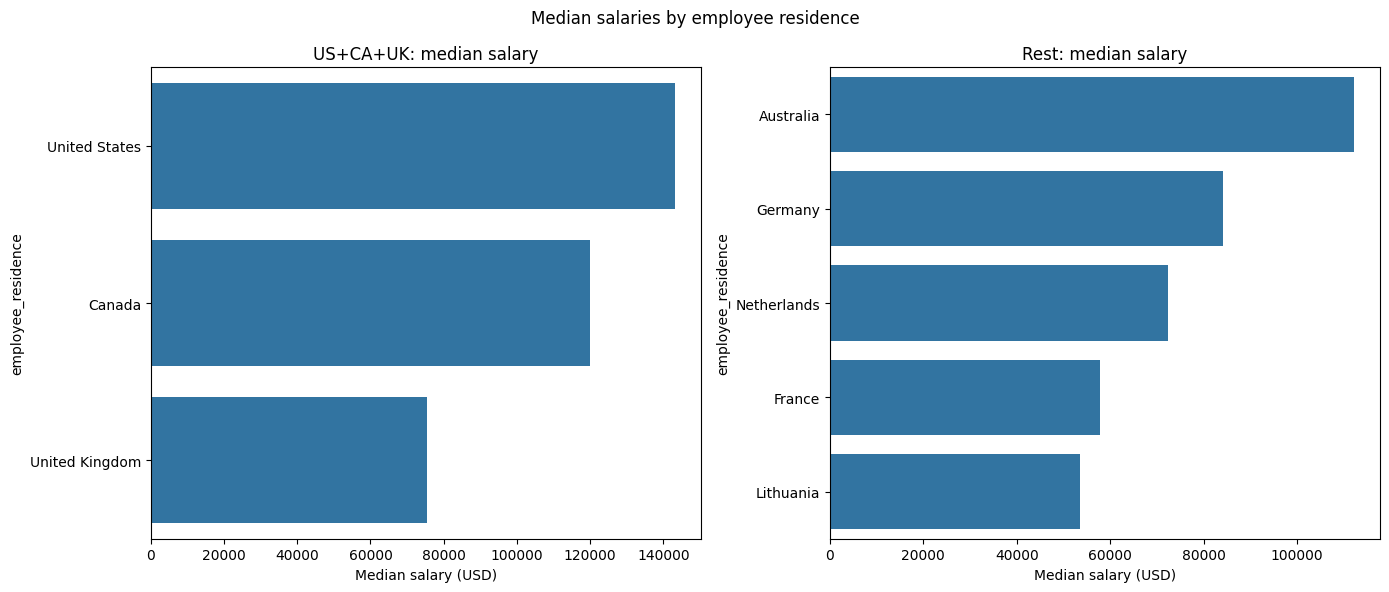

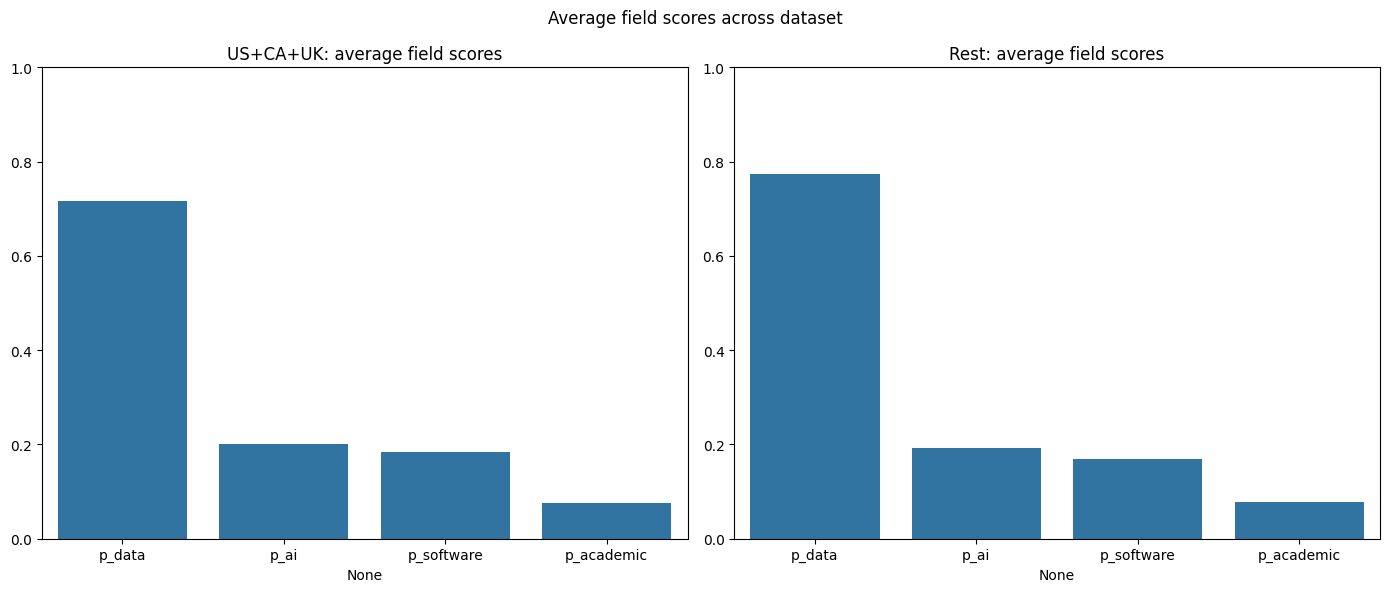

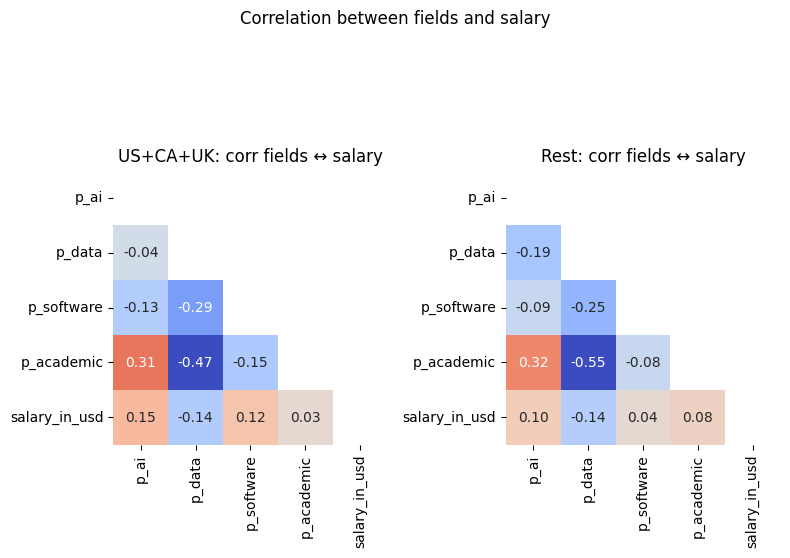

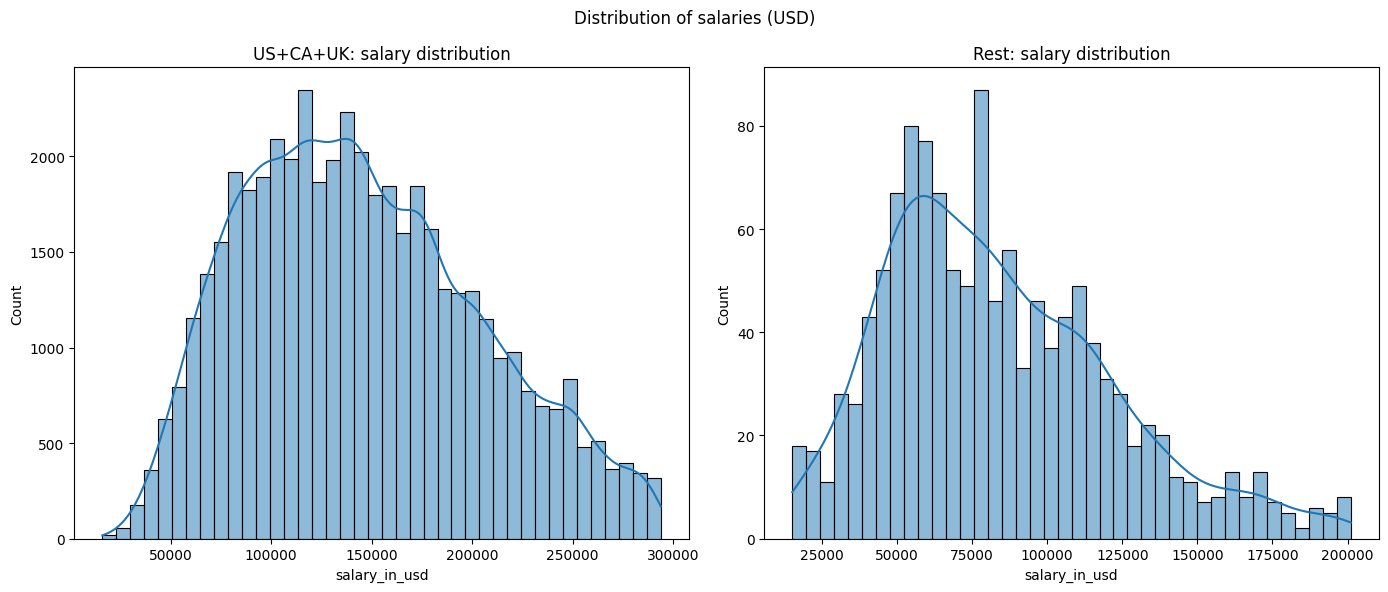

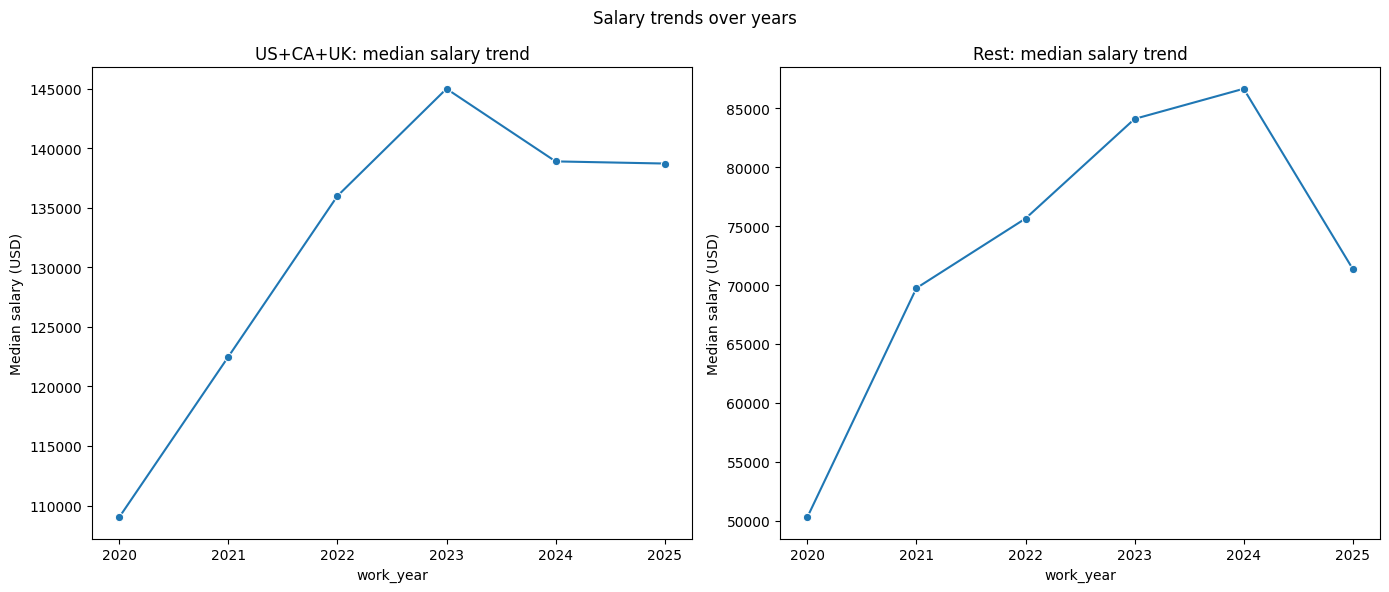

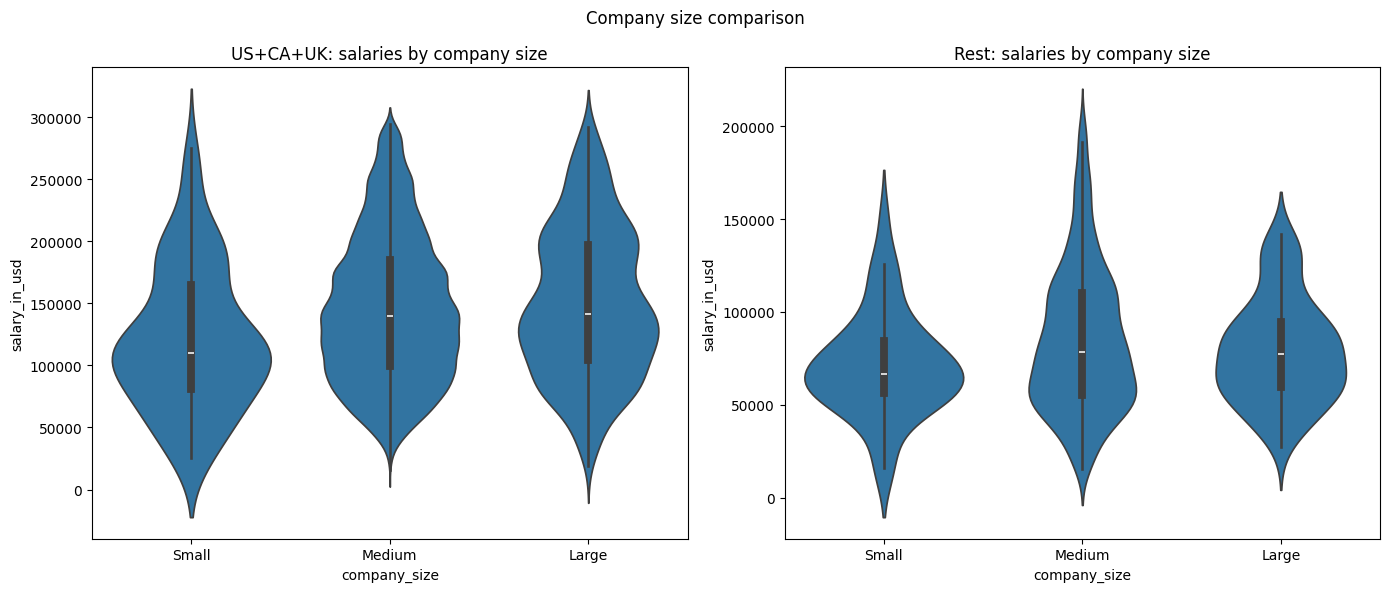

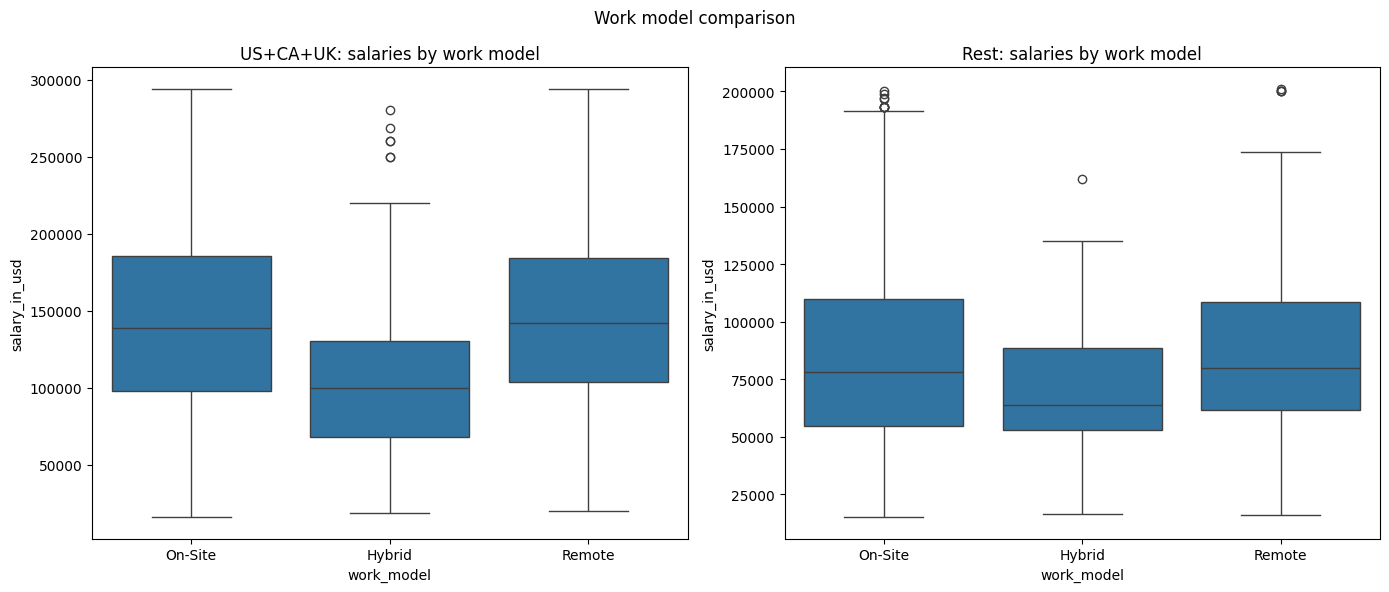

In [7]:
report_eda = RegionEDA(us_ca_uk, rest, os.path.join(MAPS_DIR, "orders.json"))

report_eda.geography_salary()
report_eda.field_profiles()
report_eda.salary_distributions()
report_eda.salary_trends()
report_eda.salary_vs_company_size()
report_eda.salary_vs_work_model()

## EDA – kluczowe wyniki porównawcze (US+CA+UK vs. Rest)

### Median salaries by employee residence
- **USA** (~145k USD) i **Kanada** (~120k USD) dominują globalnie; **UK** znacznie niżej (~75k USD).  
- W grupie „Rest” wyróżnia się **Australia** (~112k USD), dalej **Niemcy** (~85k), **Holandia** (~72k), **Francja** (~58k), **Litwa** (~52k).  

-> **Wniosek:** Lokalizacja jest jednym z kluczowych czynników – rynek amerykański i anglosaski wyraźnie przewyższa Europę kontynentalną.  

---

### Average field scores
- **p_data** (0.7–0.8) – dominują kompetencje związane z analizą danych.  
- **p_ai** (~0.2) – zauważalny, ale wciąż mniejszy segment.  
- **p_software** (~0.18) i **p_academic** (<0.1) – marginalne.  

-> **Wniosek:** rynek pracy opiera się głównie na rolach związanych z danymi; AI to rosnąca, ale wciąż mniejsza specjalizacja.  

---

### Correlation between fields and salary
- **US+CA+UK**: lekko dodatnia korelacja płac z AI i pracą akademicką (~0.1–0.3), brak związku lub ujemna korelacja dla data/software.  
- **Rest**: podobnie, ale **p_academic** ma najwyższą korelację (~0.32), choć przy małej próbie.  

-> **Wniosek:** niszowe obszary (AI, akademia) mogą wiązać się z premią płacową, typowe role data/software – niekoniecznie.  

---

### Distribution of salaries
- **US+CA+UK**: najwięcej płac w widełkach 100k–150k USD, częste >200k USD.  
- **Rest**: szczyt w widełkach 50k–80k USD, rzadkie >150k USD.  

-> **Wniosek:** rynek anglosaski oferuje wyraźnie wyższe płace i większe zróżnicowanie wynagrodzeń.  

---

### Salary trends over years
- **US+CA+UK**: wzrost z ~109k (2020) do ~145k (2023), następnie stabilizacja/spadek.  
- **Rest**: wzrost do 2024 (~87k), potem spadek w 2025 (~72k).  

-> **Wniosek:** globalny trend wzrostu płac wyhamował po 2023, szczególnie poza krajami anglosaskimi.  

---

### Company size comparison
- **US+CA+UK**: najwyższe mediany i najszerszy rozrzut w firmach **Large**.  
- **Rest**: podobny trend, ale na niższych poziomach.  

-> **Wniosek:** większe firmy częściej oferują wyższe wynagrodzenia i szersze widełki.  

---

### Work model comparison
- **US+CA+UK**: **On-site** i **Remote** podobne (~140k), **Hybrid** niżej.  
- **Rest**: mediany ~75–80k, niewielkie różnice między modelami.  

-> **Wniosek:** tryb pracy (stacjonarna/zdalna/hybrydowa) nie jest głównym czynnikiem różnicującym płace – ważniejsza jest lokalizacja i rozmiar firmy.  

---

## Podsumowanie:
- **Najważniejsze czynniki płac**: lokalizacja, wielkość firmy, obszar specjalizacji (AI i akademia mogą dawać przewagę).  
- **US+CA+UK**: najwyższe płace, szersze widełki, trend wzrostowy do 2023.  
- **Rest**: niższe mediany, duże zróżnicowanie regionalne, spadek po 2024.  
- **Model pracy**: ma drugorzędne znaczenie wobec regionu i firmy.  

-> EDA jasno pokazuje, że globalne różnice w wynagrodzeniach wynikają przede wszystkim z **lokalizacji** i **specjalizacji**, a nie z samego trybu pracy.


<br><br><br>
## Model XGBoost – segment **US+CA+UK**
Strojenie (`tune(n_trials=50)`) i trenowanie (`fit()`) na podziale **train/val 80/20** z `early_stopping`. Model akceptuje kategorie (`enable_categorical=True`, `tree_method='hist'`).

In [8]:
xgb_us_ca_uk = XGBoost(us_ca_uk)

xgb_us_ca_uk.tune(50)
xgb_us_ca_uk.fit()

[I 2025-09-27 09:49:14,148] A new study created in memory with name: no-name-c29d7382-4557-4a6f-99fc-a874a42efa18


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-27 09:49:26,548] Trial 0 finished with value: 58426.66131142528 and parameters: {'n_estimators': 2342, 'learning_rate': 1.3401958989018354e-05, 'max_depth': 11}. Best is trial 0 with value: 58426.66131142528.
[I 2025-09-27 09:49:31,236] Trial 1 finished with value: 52439.68207378836 and parameters: {'n_estimators': 1908, 'learning_rate': 0.0003313521907474857, 'max_depth': 7}. Best is trial 1 with value: 52439.68207378836.
[I 2025-09-27 09:49:37,570] Trial 2 finished with value: 57931.20775540589 and parameters: {'n_estimators': 838, 'learning_rate': 7.369378970186385e-05, 'max_depth': 14}. Best is trial 1 with value: 52439.68207378836.
[I 2025-09-27 09:49:42,636] Trial 3 finished with value: 57772.616904550894 and parameters: {'n_estimators': 2219, 'learning_rate': 3.324891925000429e-05, 'max_depth': 7}. Best is trial 1 with value: 52439.68207378836.
[I 2025-09-27 09:49:45,579] Trial 4 finished with value: 57940.113634683185 and parameters: {'n_estimators': 2356, 'learning_

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,20
,enable_categorical,True
,eval_metric,None


Interpretacja:

- RMSE ~49k oznacza, że średni błąd kwadratowy odpowiada mniej więcej ±50 tys. w jednostkach Twojej zmiennej zależnej (tu chyba wynagrodzenie).
- MAE ~40k to przeciętny błąd bezwzględny – model myli się średnio o około 40k.
- R² ~0.30 oznacza, że model tłumaczy około 30% wariancji w danych. To nie jest bardzo dobry wynik – znaczy, że sporo zależy od czynników, których model nie widzi, albo że dane są bardzo rozproszone.

### Co to mówi praktycznie?

- Model nauczył się czegoś (R² > 0), więc uchwycił istotne zależności (np. stanowisko, waluta, doświadczenie – co widać w SHAP).
- Jednocześnie jest spory margines błędu – więc na poziomie indywidualnym przewidywania mogą być mocno nietrafione.
- Model jest raczej użyteczny do analiz trendów i porównań, a nie do dokładnego przewidywania pojedynczych wartości.

In [9]:
xgb_rest = XGBoost(rest)

xgb_rest.tune(50)
xgb_rest.fit()

[I 2025-09-27 09:50:41,224] A new study created in memory with name: no-name-54f64be7-3e4b-4723-899e-784990da90eb


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-27 09:50:43,467] Trial 0 finished with value: 40026.28416428385 and parameters: {'n_estimators': 1691, 'learning_rate': 3.8114477843573556e-05, 'max_depth': 13}. Best is trial 0 with value: 40026.28416428385.
[I 2025-09-27 09:50:43,742] Trial 1 finished with value: 30348.956094073485 and parameters: {'n_estimators': 2552, 'learning_rate': 0.005674973181465597, 'max_depth': 2}. Best is trial 1 with value: 30348.956094073485.
[I 2025-09-27 09:50:43,776] Trial 2 finished with value: 30488.553130642325 and parameters: {'n_estimators': 2297, 'learning_rate': 0.2249899279724591, 'max_depth': 5}. Best is trial 1 with value: 30348.956094073485.
[I 2025-09-27 09:50:43,876] Trial 3 finished with value: 31376.655781010188 and parameters: {'n_estimators': 844, 'learning_rate': 0.03976190936024066, 'max_depth': 9}. Best is trial 1 with value: 30348.956094073485.
[I 2025-09-27 09:50:44,390] Trial 4 finished with value: 30360.71356210193 and parameters: {'n_estimators': 1429, 'learning_rat

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,20
,enable_categorical,True
,eval_metric,None


Interpretacja:

- RMSE ~30k oznacza, że średni błąd kwadratowy odpowiada mniej więcej ±30 tys. w jednostkach zmiennej zależnej (prawdopodobnie wynagrodzenie).
- MAE ~21,8k to przeciętny błąd bezwzględny – model myli się średnio o około 22 tys.
- R² ~0.46 oznacza, że model tłumaczy ok. 46% wariancji w danych. To wyraźnie lepiej niż wcześniejszy wynik (~0.30), ale nadal oznacza, że ponad połowa zmienności zależy od czynników niewidocznych w danych albo od dużego szumu.

### Co to mówi praktycznie?

- Model wyraźnie lepiej uczy się zależności – uchwycił więcej struktury i przewiduje z mniejszym błędem niż poprzedni (mniejsze RMSE i MAE, wyższe R²).
- Nadal jednak błędy jednostkowe są spore – przy wynagrodzeniach myli się średnio o ~22 tys., więc prognoza dla pojedynczej osoby może mocno odbiegać od rzeczywistości.
- Model jest bardziej użyteczny do analiz porównawczych i trendów (np. które cechy najmocniej podbijają płacę) niż do precyzyjnych prognoz indywidualnych wynagrodzeń.

<br><br><br>
## SHAP – interpretacja modeli
Obliczamy wartości SHAP dla modelu segmentu *Rest* (po zakodowaniu kategorii do kodów). Tworzymy trzy wykresy: **summary**, **bar** (global importance) i **waterfall** (wyjaśnienie lokalne).

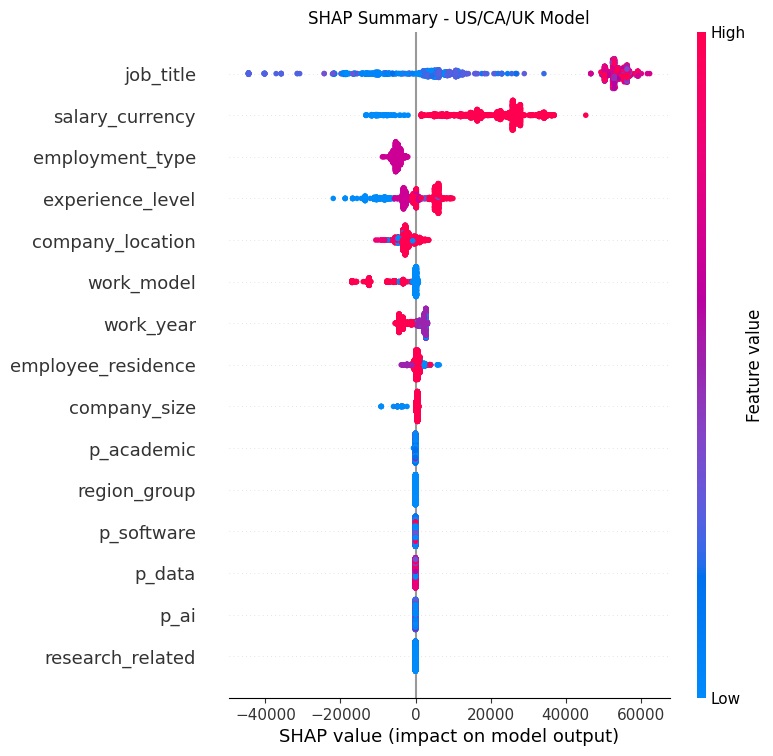

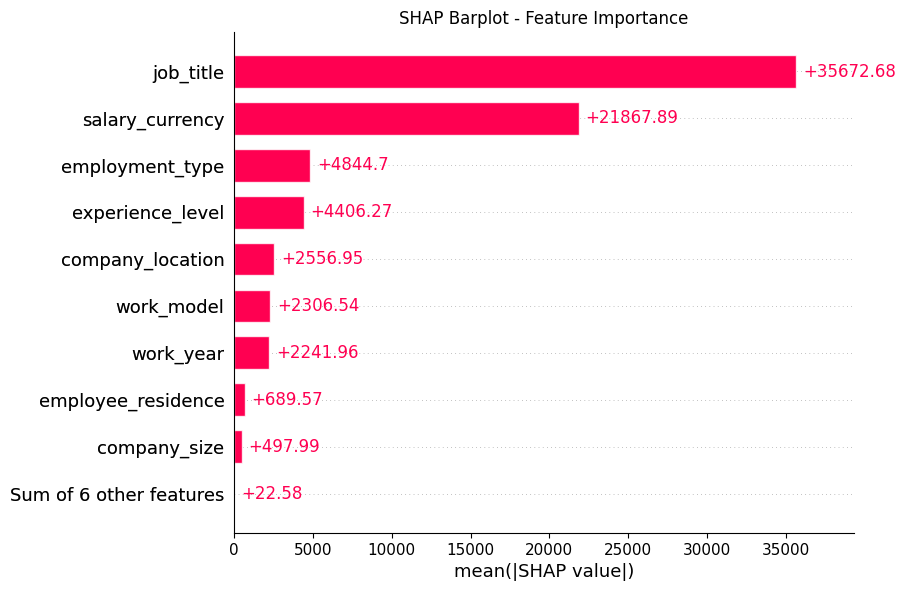

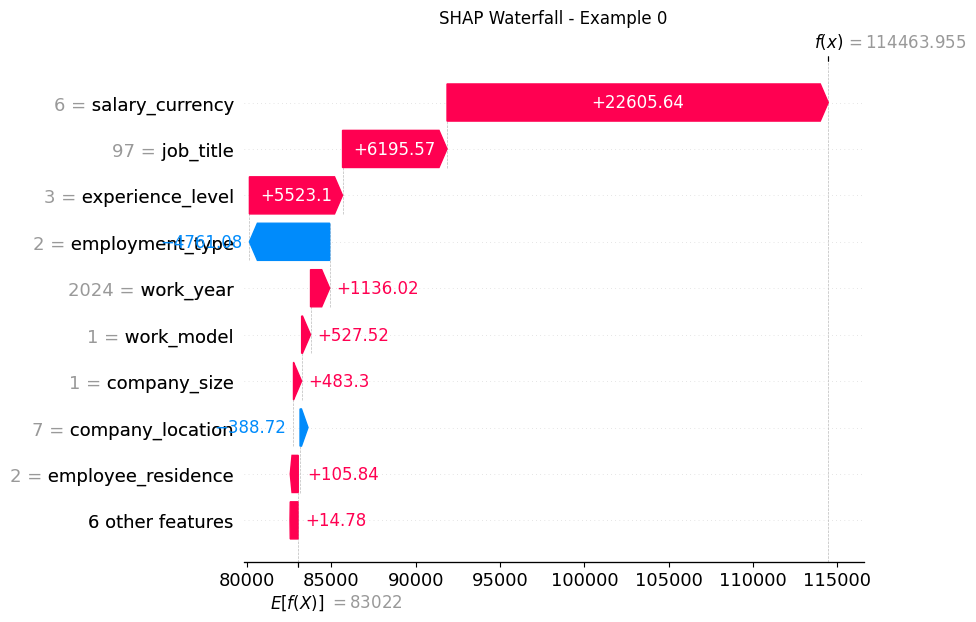

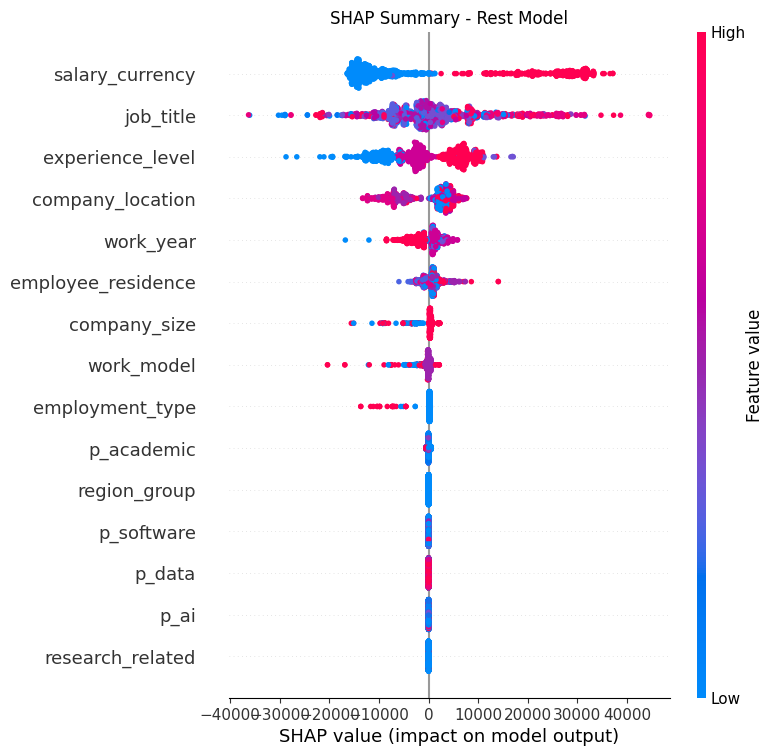

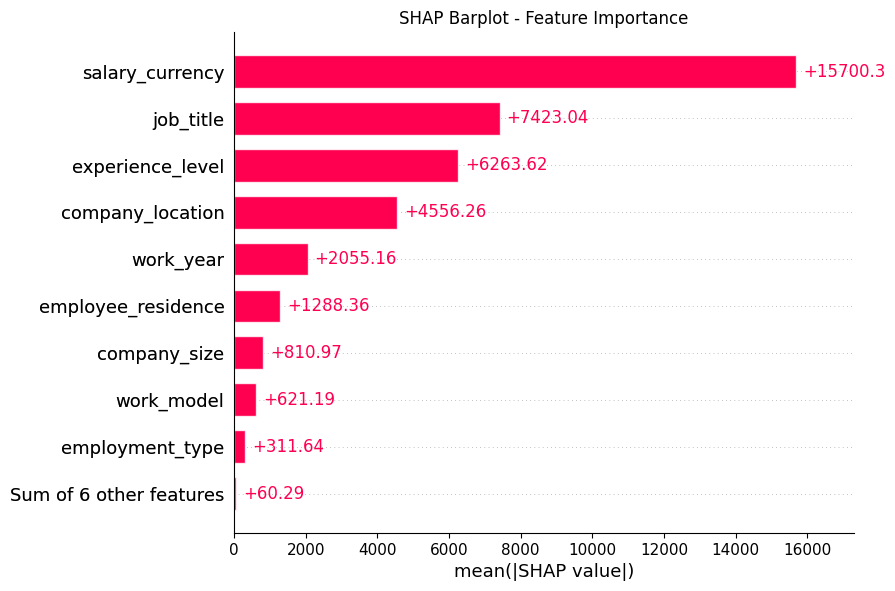

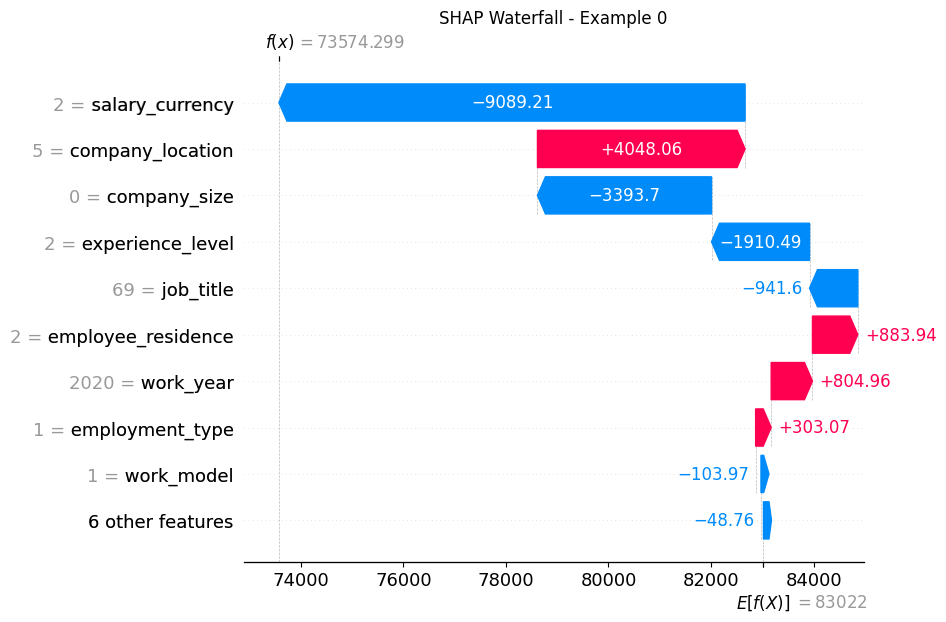

In [11]:
import matplotlib.pyplot as plt
import shap

# zrób wersję danych numerycznych tylko do SHAP
X_numeric = xgb_us_ca_uk.X.copy()
for col in X_numeric.select_dtypes(include="category"):
    X_numeric[col] = X_numeric[col].cat.codes

n_samples = min(2000, len(X_numeric))
X_numeric = X_numeric.sample(n=n_samples, random_state=42)

# TreeExplainer dla XGBoost
explainer = shap.TreeExplainer(xgb_rest.model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_numeric)

# summary plot z tytułem
shap.summary_plot(shap_values, X_numeric, show=False)
plt.title("SHAP Summary - US/CA/UK Model")
plt.show()

# bar plot z tytułem
shap.plots.bar(shap_values, show=False)
plt.title("SHAP Barplot - Feature Importance")
plt.show()

# waterfall dla jednej obserwacji
shap.plots.waterfall(shap_values[0], show=False)
plt.title("SHAP Waterfall - Example 0")
plt.show()





# zrób wersję danych numerycznych tylko do SHAP
X_numeric = xgb_rest.X.copy()
for col in X_numeric.select_dtypes(include="category"):
    X_numeric[col] = X_numeric[col].cat.codes

# TreeExplainer dla XGBoost
explainer = shap.TreeExplainer(xgb_rest.model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_numeric)

# summary plot z tytułem
shap.summary_plot(shap_values, X_numeric, show=False)
plt.title("SHAP Summary - Rest Model")
plt.show()

# bar plot z tytułem
shap.plots.bar(shap_values, show=False)
plt.title("SHAP Barplot - Feature Importance")
plt.show()

# waterfall dla jednej obserwacji
shap.plots.waterfall(shap_values[0], show=False)
plt.title("SHAP Waterfall - Example 0")
plt.show()


# US/CA/UK Model

## Summary plot (globalny rozkład)

- Stanowisko (job_title) i waluta (salary_currency) najmocniej kształtują prognozy.
- Ważne także: typ zatrudnienia i poziom doświadczenia.
- Lokalizacja firmy, rok pracy i tryb pracy mają zauważalny, ale mniejszy wpływ.
- Pozostałe cechy odgrywają rolę marginalną.

## Bar plot (ranking cech)

- Stanowisko i waluta dominują – ich wpływ jest o rząd wielkości większy niż innych zmiennych.
- Kolejne czynniki to: typ zatrudnienia, doświadczenie, lokalizacja firmy.
- Reszta cech (np. rozmiar firmy, miejsce zamieszkania) to tylko drobne korekty.
- Waterfall plot (jedna obserwacja)

## Model przewidział 114k vs średnia 83k.

- Wynik mocno podbiły: waluta (+22k), stanowisko (+6k) i doświadczenie (+5,5k).
- Typ zatrudnienia (-4,7k) odjął część wartości.
- Kilka mniejszych czynników (rok, tryb pracy, firma) dodało po kilkaset.

**Bardzo wysoka prognoza, napędzana głównie trzema kluczowymi cechami.**

# Rest

## Summary plot (globalny rozkład)

- Najważniejszym czynnikiem jest waluta wypłaty – mocno różnicuje prognozowane zarobki.
- Duże znaczenie ma też stanowisko oraz poziom doświadczenia.
- Lokalizacja firmy i rok pracy wpływają na wynik, ale słabiej.
- Reszta cech (np. wielkość firmy, tryb pracy, miejsce zamieszkania) ma niewielki wpływ.

## Bar plot (ranking cech)

- Waluta i stanowisko dominują i wyjaśniają większość różnic w prognozach.
- Doświadczenie i lokalizacja są drugą grupą ważnych czynników.
- Pozostałe zmienne to jedynie korekty.

## Waterfall plot (jedna obserwacja)

- Model przewidział 73k zamiast średnich 83k.
- Najbardziej obniżyła prognozę waluta oraz rozmiar firmy.
- Częściowo skorygowały to na plus lokalizacja firmy i doświadczenie, ale nie wystarczyło, żeby wyrównać stratę.

**Wynik końcowy jest więc niższy niż średnia.**



---

# Kierunki rozwoju

1. **Lepsze dopasowanie modelu**  
   Zamiast pojedynczych testów można przeprowadzić setki prób, aby znaleźć najlepsze ustawienia i sprawdzić, czy model dobrze działa w kolejnych latach, a nie tylko w całej próbie naraz.  

2. **Lepsze przygotowanie danych o płacach**  
   Można zmienić sposób liczenia wartości wynagrodzeń (np. użyć skali logarytmicznej) oraz dostosować je do regionów, żeby porównania były bardziej uczciwe i realistyczne.  

3. **Dodanie dodatkowych czynników**  
   Warto wzbogacić dane o takie informacje jak: koszty życia w różnych krajach, wskaźniki gospodarcze czy dokładniejszy opis stanowisk i poziomu doświadczenia. Trzeba też uważać, by model nie dyskryminował pewnych grup.  

4. **Sprawdzenie aktualności prognoz**  
   Testowanie modelu tylko na danych z ostatniego roku pozwoli ocenić, czy potrafi przewidywać obecne płace. Dodatkowo warto śledzić, czy w czasie nie zmienia się struktura rynku, co mogłoby obniżyć trafność prognoz.  
